In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [136]:
#img = cv2.imread('test_intersection.png')
img = cv2.imread('test2.png')
#img = cv2.imread('test3.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#hsv = cv2.GaussianBlur(hsv, (51, 51), 0)

lower_bound = np.array([0, 0, 50]) # H=0, S=0, V=50
upper_bound = np.array([180, 50, 150])

# Create a mask based on this range
mask = cv2.inRange(hsv, lower_bound, upper_bound)

#sobel_horizontal = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=3)
#sobel_horizontal = cv2.convertScaleAbs(sobel_horizontal)

masked_img = cv2.bitwise_and(img, img, mask=mask)

masked_img = cv2.GaussianBlur(masked_img, (15, 15), 0)

edges = cv2.Canny(masked_img, 50, 150, apertureSize=3)

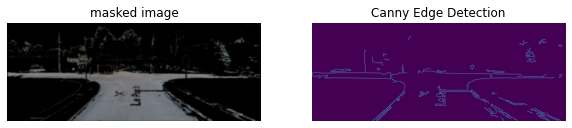

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(masked_img)
ax[0].set_title("masked image")
ax[0].axis("off")

ax[1].imshow(edges)
ax[1].set_title("Canny Edge Detection")
ax[1].axis("off")

plt.show()
plt.close()

In [ ]:
lines = cv2.HoughLinesP(
    edges, 
    rho=1,         # distance resolution in pixels
    theta=np.pi/180, # angle resolution in radians
    threshold=50,  # minimum number of votes (intersections in accumulator)
    minLineLength=50,  # minimum length of a line in pixels
    maxLineGap=10    # maximum gap between segments to consider them the same line
)

print(len(lines))
#print(lines)

4


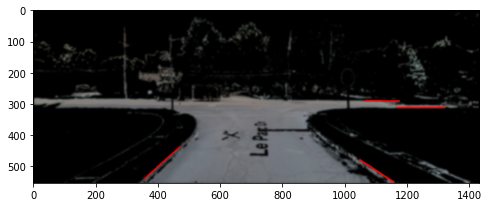

In [139]:
line_img = masked_img.copy()

for (x1, y1, x2, y2) in np.squeeze(lines):
    cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 3)

'''
cv2.imshow("Detected Horizontal Lines", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.figure(figsize=(8, 6))
plt.imshow(line_img)
plt.show()